In [35]:
import numpy as np
from MainFunctions import DrawImages, AddImageToArray, make_mesh, plt_3d
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from skimage import io, filters
from PIL import Image
import cv2
from sklearn.cluster import KMeans 

In [36]:
#original 512 x 512
i_width = 128
i_height = 128
input_shape = i_width*i_height
print(input_shape)

16384


In [37]:
x = []

AddImageToArray(x ,'DICOM\PA1\ST1\SE4', (i_width, i_height))

x = np.array(x, np.float32)

In [38]:
def segmentation(images, left_offset, right_offset):
    width = images.shape[1]
    height = images.shape[2]
    x_transforms = np.where(images > 100, 1, 0)
    x_transforms = np.array(x_transforms, np.float32)
    for img in x_transforms:
        for i in range(0, height):
            for j in range(0, left_offset):
                img[i,j] = 0
        for i in range(0, height):
            for j in range(width - right_offset, width):
                img[i,j] = 0
    return np.array(x_transforms)

In [39]:
def addNoise(image, x1,x2,y1,y2,value =0,max_replased = 100):
    if x1 > x2:
        box = x2
        x2 = x1
        x1 = box
    if y1 > y2:
        box = y2
        y2 = y1
        y1 = box
    k = 0
    for i in range(x1,x2):
        if k >= max_replased:
            break
        for j in range(y1,y2):
            if k >= max_replased:
                break
            if image[i,j] > 0:
                image[i,j] = value
                k+=1
                
def addLeftNoise(images, value=0, offset = 50, max_replased = 100):
    items = np.array(images)
    shape = items.shape
    for image in items:
        x1 = np.random.randint(shape[1]/2-offset, shape[1]/2)
        x2 = np.random.randint(0, shape[1])
        y1 = np.random.randint(shape[2]/2-offset, shape[2]/2)
        y2 = 0

        addNoise(image,x1,x2,y1,y2, value, max_replased)
                
    return items

def addRightNoise(images, value=0, offset = 50, max_replased = 100):
    items = np.array(images)
    shape = items.shape
    for image in items:
        x1 = np.random.randint(shape[1]/2+offset, shape[1])
        x2 = np.random.randint(0, shape[1])
        y1 = np.random.randint(shape[2]/2+offset, shape[2])
        y2 = shape[2]

        addNoise(image,x1,x2,y1,y2, value, max_replased)
                
    return items

In [105]:
import random as rnd
import scipy.ndimage.interpolation as interp
def move_skull(skull_imgs, max_offset = [10,10]):
    outputs = []
    for skull_img in np.array(skull_imgs):
        labels = np.where(skull_img == 1)
        first_indx = np.array([np.argmin(labels[0]),np.argmin(labels[1])])
        last_indx = np.array([np.argmax(labels[0]),np.argmax(labels[1])])

        first_xy_value = [labels[0][first_indx[0]], labels[1][first_indx[1]]]
        last_xy_value = [labels[0][last_indx[0]], labels[1][last_indx[1]]]

        subarr = skull_img[first_xy_value[0]: last_xy_value[0],
                           first_xy_value[1]: last_xy_value[1]].copy()  # duplicate values
        
        sub_shape = subarr.shape
        angle = rnd.randint(1,359)
        subarr = cv2.resize(interp.rotate(subarr, angle), sub_shape)

        skull_img[first_xy_value[0]: last_xy_value[0],
                  first_xy_value[1]: last_xy_value[1]] = 0  # remove original values
        
        val_min = np.minimum(np.minimum(first_xy_value, last_xy_value),max_offset)

        x = rnd.randint(-val_min[0]+1,val_min[0])
        y = rnd.randint(-val_min[1]+1,val_min[1])
        if subarr.shape == sub_shape:
            skull_img[first_xy_value[0] + x: last_xy_value[0] + x,
                    first_xy_value[1] + y: last_xy_value[1] + y] = subarr  # put in new place
        else:
            skull_img[first_xy_value[1] + y: last_xy_value[1] + y,
                    first_xy_value[0] + x: last_xy_value[0] + x] = subarr  # put in new place
        outputs.append(skull_img)
    return np.where(np.array(outputs)>0.1,1,0)


C:\Users\ivan_\AppData\Local\Temp\ipykernel_6816\1032105977.py:18: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  subarr = cv2.resize(interp.rotate(subarr, angle), sub_shape)


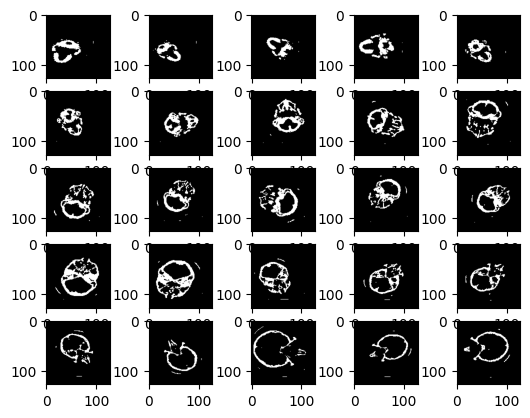

In [107]:
import scipy.ndimage.interpolation as interp
y = move_skull(segmentation(x, 21,21))
DrawImages(y,25,(5,5))

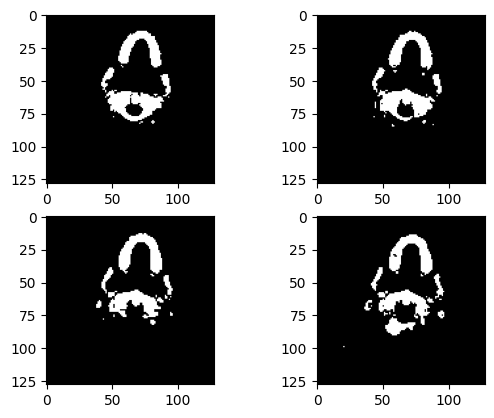

In [ ]:
y = segmentation(x, 20,20)
DrawImages(y)

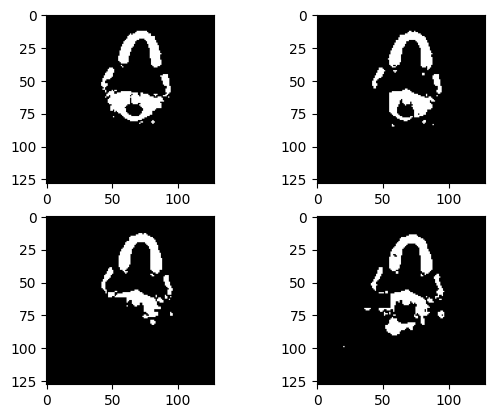

In [ ]:
DrawImages(addLeftNoise(y,0,10,1000))

In [ ]:
k = 1
for img in y:
    cv2.imwrite("TrainData\{0}.png".format(k), img*1000)
    k+=1

In [ ]:
y_resized = np.array([cv2.resize(i, (512,512)) for i in y])

In [ ]:
y_resized.shape

(68, 512, 512)

In [ ]:
v, f = make_mesh(y_resized, 0,1)
plt_3d(v, f, 'test_examples.stl')

KeyboardInterrupt: 